In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from natsort import natsorted
import pandas as pd


import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import sys
sys.path.insert(0,'../../../purity-monitor/')
sys.path.insert(0,'../../WaveformAnalysis')

In [3]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [4]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [5]:
D1 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/', 
                    Selection='*DCR*rename*.h5')
D1.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D1.Files))
for i,File in enumerate(natsorted(D1.Files)[:50]):
    print(i, File)
    print('Getting data...')
    D1.ImportDataFromHDF5(File, D1.Ch)

#     print('Getting sampling information...')
    D1.get_sampling()

#     print('Getting filtered waveforms...')
    D1.Ch[0].Amp = D1.run_filter(D1.Ch[0].Amp)

#     print('Getting deconvolved waveforms...')
    D1.Ch[0].Deconv = D1.run_deconvolution(D1.Ch[0].Amp)

#     print('Getting peak amplitudes and positions...')
    D1.get_peaks(D1.Ch[0].Deconv)

#     print('Clearing variables...')
    D1.clear()

204
0 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_0.h5
Getting data...
Getting deconvolution filter...
1 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_1.h5
Getting data...
2 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_2.h5
Getting data...
3 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_3.h5
Getting data...
4 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_4.h5
Getting data...
5 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_5.h5
Getting data...
6 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_6.h5
Getting data...
7 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_7.h5
Getting data...
8 /project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211126/GXe_SiPM_DCR_30V_rename_8.h5
Getting 

24.13671051081676


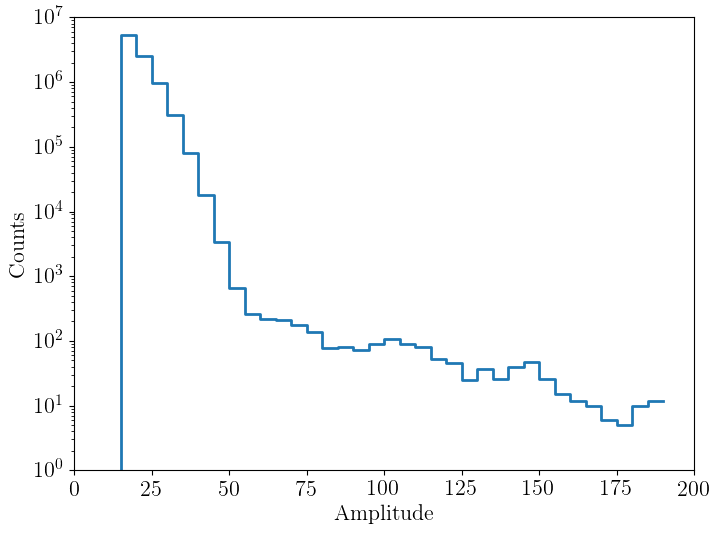

[]


In [14]:
def gauss_func(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

h,hx = np.histogram(D1.peak_height, bins=np.arange(0,200,5))

pe = np.median(D1.peak_height)
print(pe)
pe_fit = []

plt.figure()
for i in range(1,7):
    cut = np.where((hx[:-1]>pe*i-6) & (hx[:-1]<pe*i+(7/i)))
#     print (pe*i-8,pe*i+(6/i))
    
# #     popt,pcov = curve_fit(gauss_func, hx[:-1][cut], h[cut], 
#                           p0=[np.max(h[cut]), pe*i,10],maxfev=100000)
# #     pe_fit.append(popt)
# #     plt.plot(hx[:-1][cut], gauss_func(hx[:-1][cut], *popt), color='r', zorder=10)

# pe_fit = np.array(pe_fit)    
# plt.hist(D1.peak_height, bins=np.arange(0,200,1))
plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2)
plt.savefig('deconvolution_hist_pe_11-26-21.pdf')
plt.show()
print (pe_fit)

In [15]:
gain = np.diff(pe_fit[:,1])
print (gain)
gain = np.insert(gain,0,pe_fit[0,1])
D1.peak_height_calib = np.array(D1.peak_height)/np.mean(gain)
ca = (np.mean(D1.peak_height_calib[(D1.peak_height_calib<7) & (D1.peak_height_calib>0)]) - 1)*100
print (ca)

h,hx = np.histogram(D1.peak_height_calib, bins=np.arange(0,10,0.05))

plt.figure()
plt.grid()
plt.xticks(np.arange(0,10,1))
plt.xlabel('Number of p.e.')
plt.ylabel('Counts')
plt.yscale('log')
plt.step(hx[:-1], h, lw=2, where='post', label='$\Lambda={:.2f}$\% at 30V'.format(ca))
plt.legend(loc='upper right')
plt.savefig('deconvolution_hist_pe_calib_11-26-21.pdf')
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [16]:
res = np.abs(pe_fit[:,2])/pe_fit[:,1]
fit_err = np.sqrt(np.diag(pcov))
res_err = np.sqrt(pe_fit[:,2]**2/pe_fit[:,1]**4 * fit_err[1]**2 + 1.0/pe_fit[:,1]**2 * fit_err[2]**2)

plt.figure()
plt.xticks(np.arange(0,len(res)+2,1))
plt.xlim(0,len(res)+1)
# plt.ylim(0,0.2)
plt.xlabel('Number of p.e.')
plt.ylabel('Peak Resolution [$\sigma/\mu$]')
plt.errorbar(np.arange(1,len(res)+1,1), res, yerr=res_err, marker='o', ms=5, label='Data')
plt.hlines(y=0.1, xmin=0, xmax=len(res)+1, ls=':', label='Specification')
plt.legend(loc='upper right')
plt.savefig('pe_resolution_11-26-21.pdf')
plt.show()

TypeError: list indices must be integers or slices, not tuple

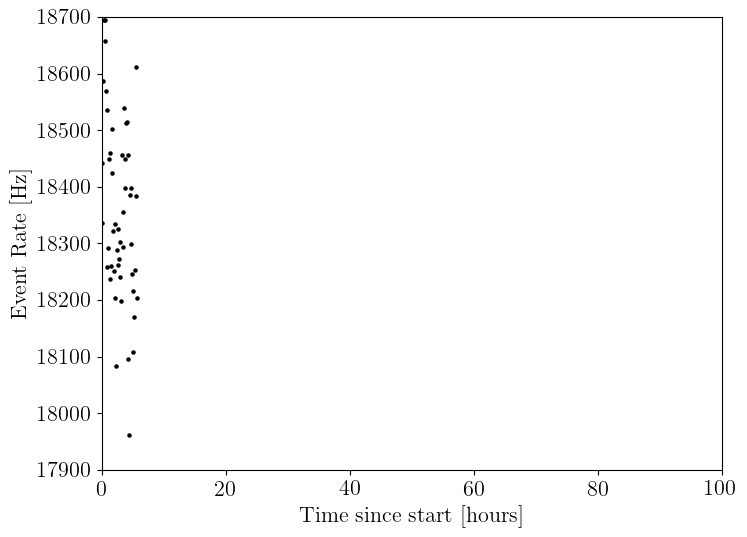

In [17]:
plt.figure()
plt.xlim(0,100)
# plt.ylim(0,15)
plt.xlabel('Time since start [hours]')
plt.ylabel('Event Rate [Hz]')
dark_count_rate_26=[]
time_26=[]
num = 100
for j in range(int(len(D1.peak_num)/num)):
    plt.scatter(j*7./60., np.sum(D1.peak_num[j*num:(j+1)*num])/(0.1*num), color='k', s=5)
    dark_count_rate_26.append(np.sum(D1.peak_num[j*num:(j+1)*num])/(0.1*num))
    time_26.append(j*7./60.)
plt.savefig('dark_count_rate_vs_time_11-26-21.pdf')
plt.show()


In [10]:
%store time_26
%store dark_count_rate_26

Stored 'time_25' (list)
Stored 'dark_count_rate_25' (list)
